In [1]:
import librosa
from numba import core
import matplotlib.pyplot as plt
import numpy as np

In [61]:
def padd_with_zeros(twod_numpy, w, h):
    old_w = twod_numpy.shape[0]
    old_h = twod_numpy.shape[1]
    h = max(old_h, h)
    w = max(old_w, w)
    lx = (w - old_w) // 2
    rx = w - lx - old_w
    ly = (h - old_h) // 2
    ry = h - ly - old_h
    return np.pad(twod_numpy, pad_width=((lx, rx), (ly, ry)), mode='constant')
def process_input_file(filename):

    waveform, sample_rate = librosa.load(filename)

    n_fft = 512  # Number of FFT points (window size)
    hop_length = 1024  # Hop length (frame shift)

    # Compute the STFT
    stft = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    # normalize
    # stft = (stft-np.min(stft))/(np.max(stft)-np.min(stft))
    normalized_stft = stft / np.linalg.norm(stft)
    print(np.max(normalized_stft), np.min(normalized_stft))

    padded = padd_with_zeros(normalized_stft, 260, 90)
    return  padded


# filename='./data/LydoK7hXKbs-audio/audio0-10-23.00.wav'
filename='./data/a_oqcg0hvpo-audio/audio0-55-27.00.wav'
#define the beginning time of the signal

print(librosa.__version__)

data_point = process_input_file(filename)

0.10.0.post2
(0.17726892+0.080257736j) (-0.15949394+0.06683113j)


In [3]:
import os
import random
import torch
video_files=[
    # 'a_oqcg0hvpo',
    'PyFN_FYwqvc',
    # 'ubz5lz_l7IY',
    'LydoK7hXKbs'
]

tensors = {}

def get_prediction(video_name, time_stamp):
    global tensors
    local_name = f'{video_name}{time_stamp[:3]}'
    if local_name not in tensors:
        t = torch.load(f'./resnet_predictions/{video_name}/{local_name}.pth')
        tensors[local_name] = t
    else:
        t = tensors[local_name]
    return t[f'frame{time_stamp}']


DATA_PER_FILE = 125

X = []
Y = []

for video_name in video_files:
    subdir = os.listdir('./data/' + video_name + '-audio')
    files = random.choices(subdir, k=DATA_PER_FILE)
    for file in files:
        time_stamp = file[5:file.find('.')]
        label = video_name + '-' + time_stamp
        audio_data = process_input_file(f'./data/{video_name}-audio/{file}')
        classification_res = get_prediction(video_name, time_stamp)

        X.append(np.abs(audio_data))
        Y.append(classification_res)
    print(video_name)


PyFN_FYwqvc
LydoK7hXKbs


In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, shuffle=True)
BATCH_SIZE = 5
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=BATCH_SIZE)

In [47]:
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import scipy.io.wavfile as wavfile
from scipy import signal

class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = nn.Sequential( # 260 x 90
                nn.Conv2d(1, 16, stride=(1, 1), kernel_size=(3, 3), padding='same'),
                nn.LeakyReLU(0.01),
                # nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1), return_indices=True),
                nn.Conv2d(16, 32, stride=(1, 1), kernel_size=(3, 3), padding='same'),
                nn.LeakyReLU(0.01),
                nn.Dropout(0.2),
                # nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1), return_indices=True),
                # nn.Conv2d(32, 32, stride=(1, 1), kernel_size=(3, 3), padding='same'),
                # nn.LeakyReLU(0.01),
                nn.Dropout(0.2),
                nn.Flatten(),
                nn.Linear(748800, 1000)
        )
        self.classification = nn.Sequential(
                nn.Softmax(1)
        )
        self.decoder = nn.Sequential(
                nn.Linear(1000, 748800),
                nn.Unflatten(1, (32, 260, 90)),
                nn.LeakyReLU(0.01),
                # nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                # nn.MaxUnpool2d(kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.ConvTranspose2d(32, 16, stride=(1, 1), kernel_size=(3, 3), padding=1),
                # nn.MaxUnpool2d(kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, 1, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        classified = self.classification(encoded)
        decoded = self.decoder(encoded)
        return decoded, classified


In [62]:
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import scipy.io.wavfile as wavfile
from scipy import signal

class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = nn.Sequential( # 260 x 90
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(50688, 100)
        )
        self.classification = nn.Sequential(
            nn.Softmax(1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 50688),
            nn.Unflatten(1, (32, 66, 24)),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(130, 45)),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(260, 90), mode='bilinear'),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        classified = self.classification(encoded)
        decoded = self.decoder(encoded)
        return decoded, classified


In [ ]:
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import scipy.io.wavfile as wavfile
from scipy import signal

class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = nn.Sequential( # 260 x 90
                nn.Conv2d(1, 4, stride=(1, 1), kernel_size=(3, 3), padding='same'),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(4, 8, kernel_size=3, stride=1, padding='same'),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Flatten(),
                nn.Linear(11440, 1000)
        )
        self.classification = nn.Sequential(
                nn.Softmax(1)
        )
        self.decoder = nn.Sequential(
                nn.Linear(1000, 11440),
                nn.Unflatten(1, (8, 260, 90)),
                nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(4, 1, kernel_size=2, stride=2),
                nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        classified = self.classification(encoded)
        decoded = self.decoder(encoded)
        return decoded, classified

In [63]:
import torch.optim as optim
from torchvision.transforms import ToTensor
from tqdm import tqdm


# Initialize the Autoencoder
autoencoder = AutoEncoder((260, 90))

# Define the loss function
reconstruction_loss_fn = nn.MSELoss()
classication_loss_fn = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)


# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

import time

print("hello")
start = time.time()
optimizer.zero_grad()

for epoch in range(num_epochs):
    total_loss = 0.0

    # Iterate over the training dataset
    for X_batch, y_batch in tqdm(train_loader):
        X_batch = X_batch.view(BATCH_SIZE, -1, 260, 90).to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        X_pred, y_pred = autoencoder(X_batch)

        # Compute the loss
        constr_loss = reconstruction_loss_fn(X_pred, X_batch)
        # classi_loss = classication_loss_fn(y_pred, y_batch)
        loss = constr_loss # + classi_loss
        total_loss += loss.item()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss}")

    end = time.time()
    dur = end - start
    if dur > 3 * 3600:
        print(f"Elapsed {epoch} number of epochs.")
        num_epochs = epoch
        break

weight_file_name = f'model_{num_epochs}_{len(train_loader)}'
torch.save(autoencoder.state_dict(), weight_file_name)

# # Example usage after training
# test_dataset = MNIST(root='data', train=False, transform=ToTensor(), download=True)
# test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# with torch.no_grad():
#     for batch in test_loader:
#         images, _ = batch
#         images = images.view(-1, 784).to(device)
#         reconstructed = autoencoder(images)

#         # Perform any further processing or visualization with the reconstructed images

hello


100%|██████████| 40/40 [00:06<00:00,  6.09it/s]


Epoch 1/10, Average Loss: 0.09614581055939198


100%|██████████| 40/40 [00:06<00:00,  6.40it/s]


Epoch 2/10, Average Loss: 0.024571165954694153


100%|██████████| 40/40 [00:06<00:00,  6.39it/s]


Epoch 3/10, Average Loss: 0.015019214851781726


100%|██████████| 40/40 [00:06<00:00,  6.40it/s]


Epoch 4/10, Average Loss: 0.0378681039204821


100%|██████████| 40/40 [00:06<00:00,  6.39it/s]


Epoch 5/10, Average Loss: 0.033745299372822044


100%|██████████| 40/40 [00:06<00:00,  6.36it/s]


Epoch 6/10, Average Loss: 0.025207482650876044


100%|██████████| 40/40 [00:06<00:00,  6.39it/s]


Epoch 7/10, Average Loss: 0.033957799151539805


100%|██████████| 40/40 [00:06<00:00,  6.35it/s]


Epoch 8/10, Average Loss: 0.035388976358808576


100%|██████████| 40/40 [00:06<00:00,  6.31it/s]


Epoch 9/10, Average Loss: 0.02951013669371605


100%|██████████| 40/40 [00:06<00:00,  6.35it/s]

Epoch 10/10, Average Loss: 0.00803421987220645


In [ ]:
weight_file_name = f'__model_{num_epochs}_{len(train_loader)}.pth'
torch.save(autoencoder.state_dict(), weight_file_name)

In [48]:
# Create an instance of your model
autoencoder = AutoEncoder((260, 90))

# Load the saved weights
autoencoder.load_state_dict(torch.load('./_model_4_16'))

RuntimeError: Error(s) in loading state_dict for AutoEncoder:
	Missing key(s) in state_dict: "encoder.6.weight", "encoder.6.bias". 
	Unexpected key(s) in state_dict: "encoder.7.weight", "encoder.7.bias". 

(22016, 1, 1)


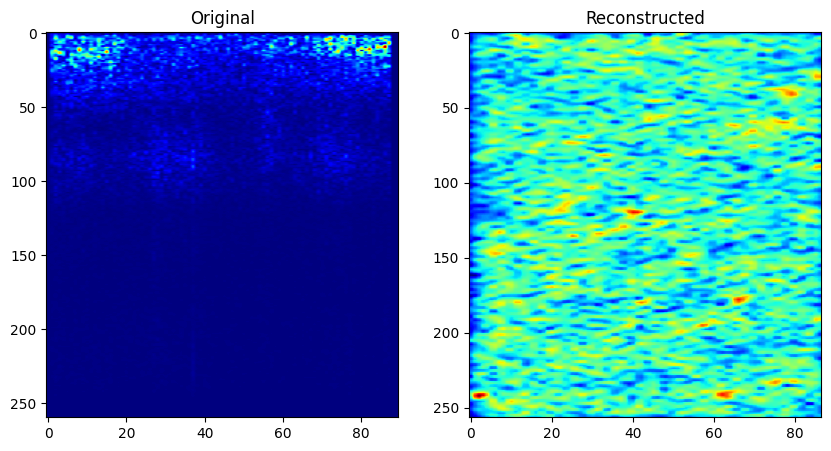

In [64]:
import torchaudio.transforms as transforms
import torchaudio
import scipy
import matplotlib
import matplotlib.pyplot as plt
import librosa

with torch.no_grad():
    # Pass the test data through the model
    # audio_data = process_input_file(f'./data/Gz99TTxmvls-audio/audio1-20-04.00.wav')
    # audio_data = process_input_file(f'./data/LydoK7hXKbs-audio/audio1-25-00.00.wav')
    audio_data = X_train[0]
    # audio_data = process_input_file(f'./data/a_oqcg0hvpo-audio/audio1-38-09.00.wav')
    test_data = audio_data[np.newaxis, np.newaxis, ...]
    test_data = torch.from_numpy(np.abs(test_data))
    reconstructed_stft, classified = autoencoder.forward(test_data)


    test_output_stft = reconstructed_stft[:, :, 1: -2, 1: -2]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    original = np.abs(audio_data)
    axs[0].imshow(original, aspect='auto', cmap='jet')
    axs[0].set_title('Original')

    res = test_output_stft.reshape(257, 87)
    axs[1].imshow(res, aspect='auto', cmap='jet')
    axs[1].set_title('Reconstructed')

    # print(res[: 10, : 10])
    # print(np.max(original), np.min(original))
    # print(original[: 10, : 10])


    n_fft = 512  # Number of FFT points (window size)
    hop_length = 1024  # Hop length (frame shift)

    # Create the STFT and iSTFT transforms
    transform_stft = transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    transform_istft = transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)


    # Reconstruct audio from the output STFT batch
    # test_reconstructed_waveform= transform_istft(test_output_stft)
    t, x = scipy.signal.istft(test_output_stft)
    # a, b = scipy.io.wavfile.read(audio_filenames[0])
    x = x.transpose()
    print(x.shape)


    plt.show()
    # Save the test examples
    scipy.io.wavfile.write('tmp.wav', 6000, x)

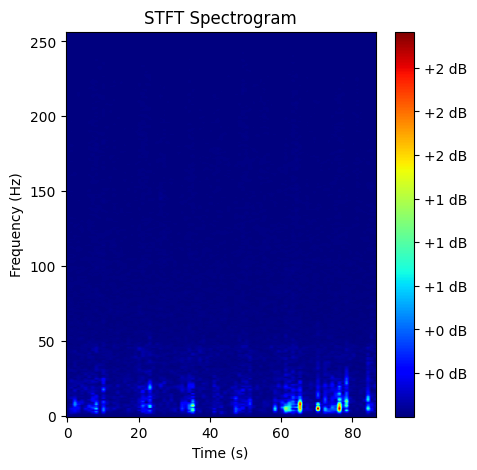

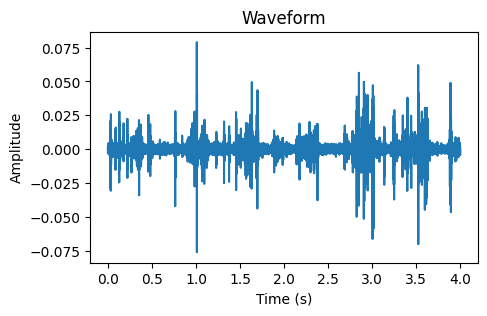

In [42]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft

# Load the audio file
audio_file = './data/LydoK7hXKbs-audio/audio1-00-30.00.wav'
waveform, sample_rate = librosa.load(filename)

n_fft = 512  # Number of FFT points (window size)
hop_length = 1024  # Hop length (frame shift)

# Compute the STFT
stft_data = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)

# Plot the STFT spectrogram
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(stft_data), aspect='auto', cmap='jet', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

# Plot the waveform
plt.figure(figsize=(5, 3))
time = np.arange(len(waveform)) / sample_rate
plt.plot(time, waveform)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()